In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mne
import scipy.io as sio
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [3]:
data = sio.loadmat('Data_Testing_pre_cleaning.mat')['data_4']
data.shape

(4, 2000000)

In [4]:
data_new = sio.loadmat('Data_Testing_pre_cleaning.mat')['data_mean'][0]
data_new.shape

(2000000,)

In [5]:
data_new.shape

(2000000,)

In [6]:
stride = 1
window = 1
sr = 2000

segments = []

numsamples = int(data_new.shape[0]/(window*sr))
for i in range(numsamples):
    segments.append(data_new[int(i*stride*sr):int((stride*(i+1))*sr)])


segment = np.array(segments)
segment.shape

(1000, 2000)

In [7]:
def signal_voltages(signal):
    # Compute vrms
    vrms = np.sqrt(np.mean(signal**2))

    # Compute vpp
    vpp = np.max(signal) - np.min(signal)
    return vrms, vpp

In [8]:
feature = []
for i in range(segment.shape[0]):
    feature.append((np.std(segment[i]), np.mean(segment[i]),signal_voltages(segment[i])[0], signal_voltages(segment[i])[1]))
feat = np.array(feature)
feat.shape

(1000, 4)

# Based on percentile of STD - 95%

In [9]:
percentile_95 = np.percentile(feat[:,0], 95)
percentile_95

17.23865608419012

In [10]:
data_std_removal = feat[:,0]

In [11]:
indices = [i for i in range(data_std_removal.shape[0]) if data_std_removal[i]<percentile_95]

In [12]:
len(indices)

950

In [13]:
len(indices)

950

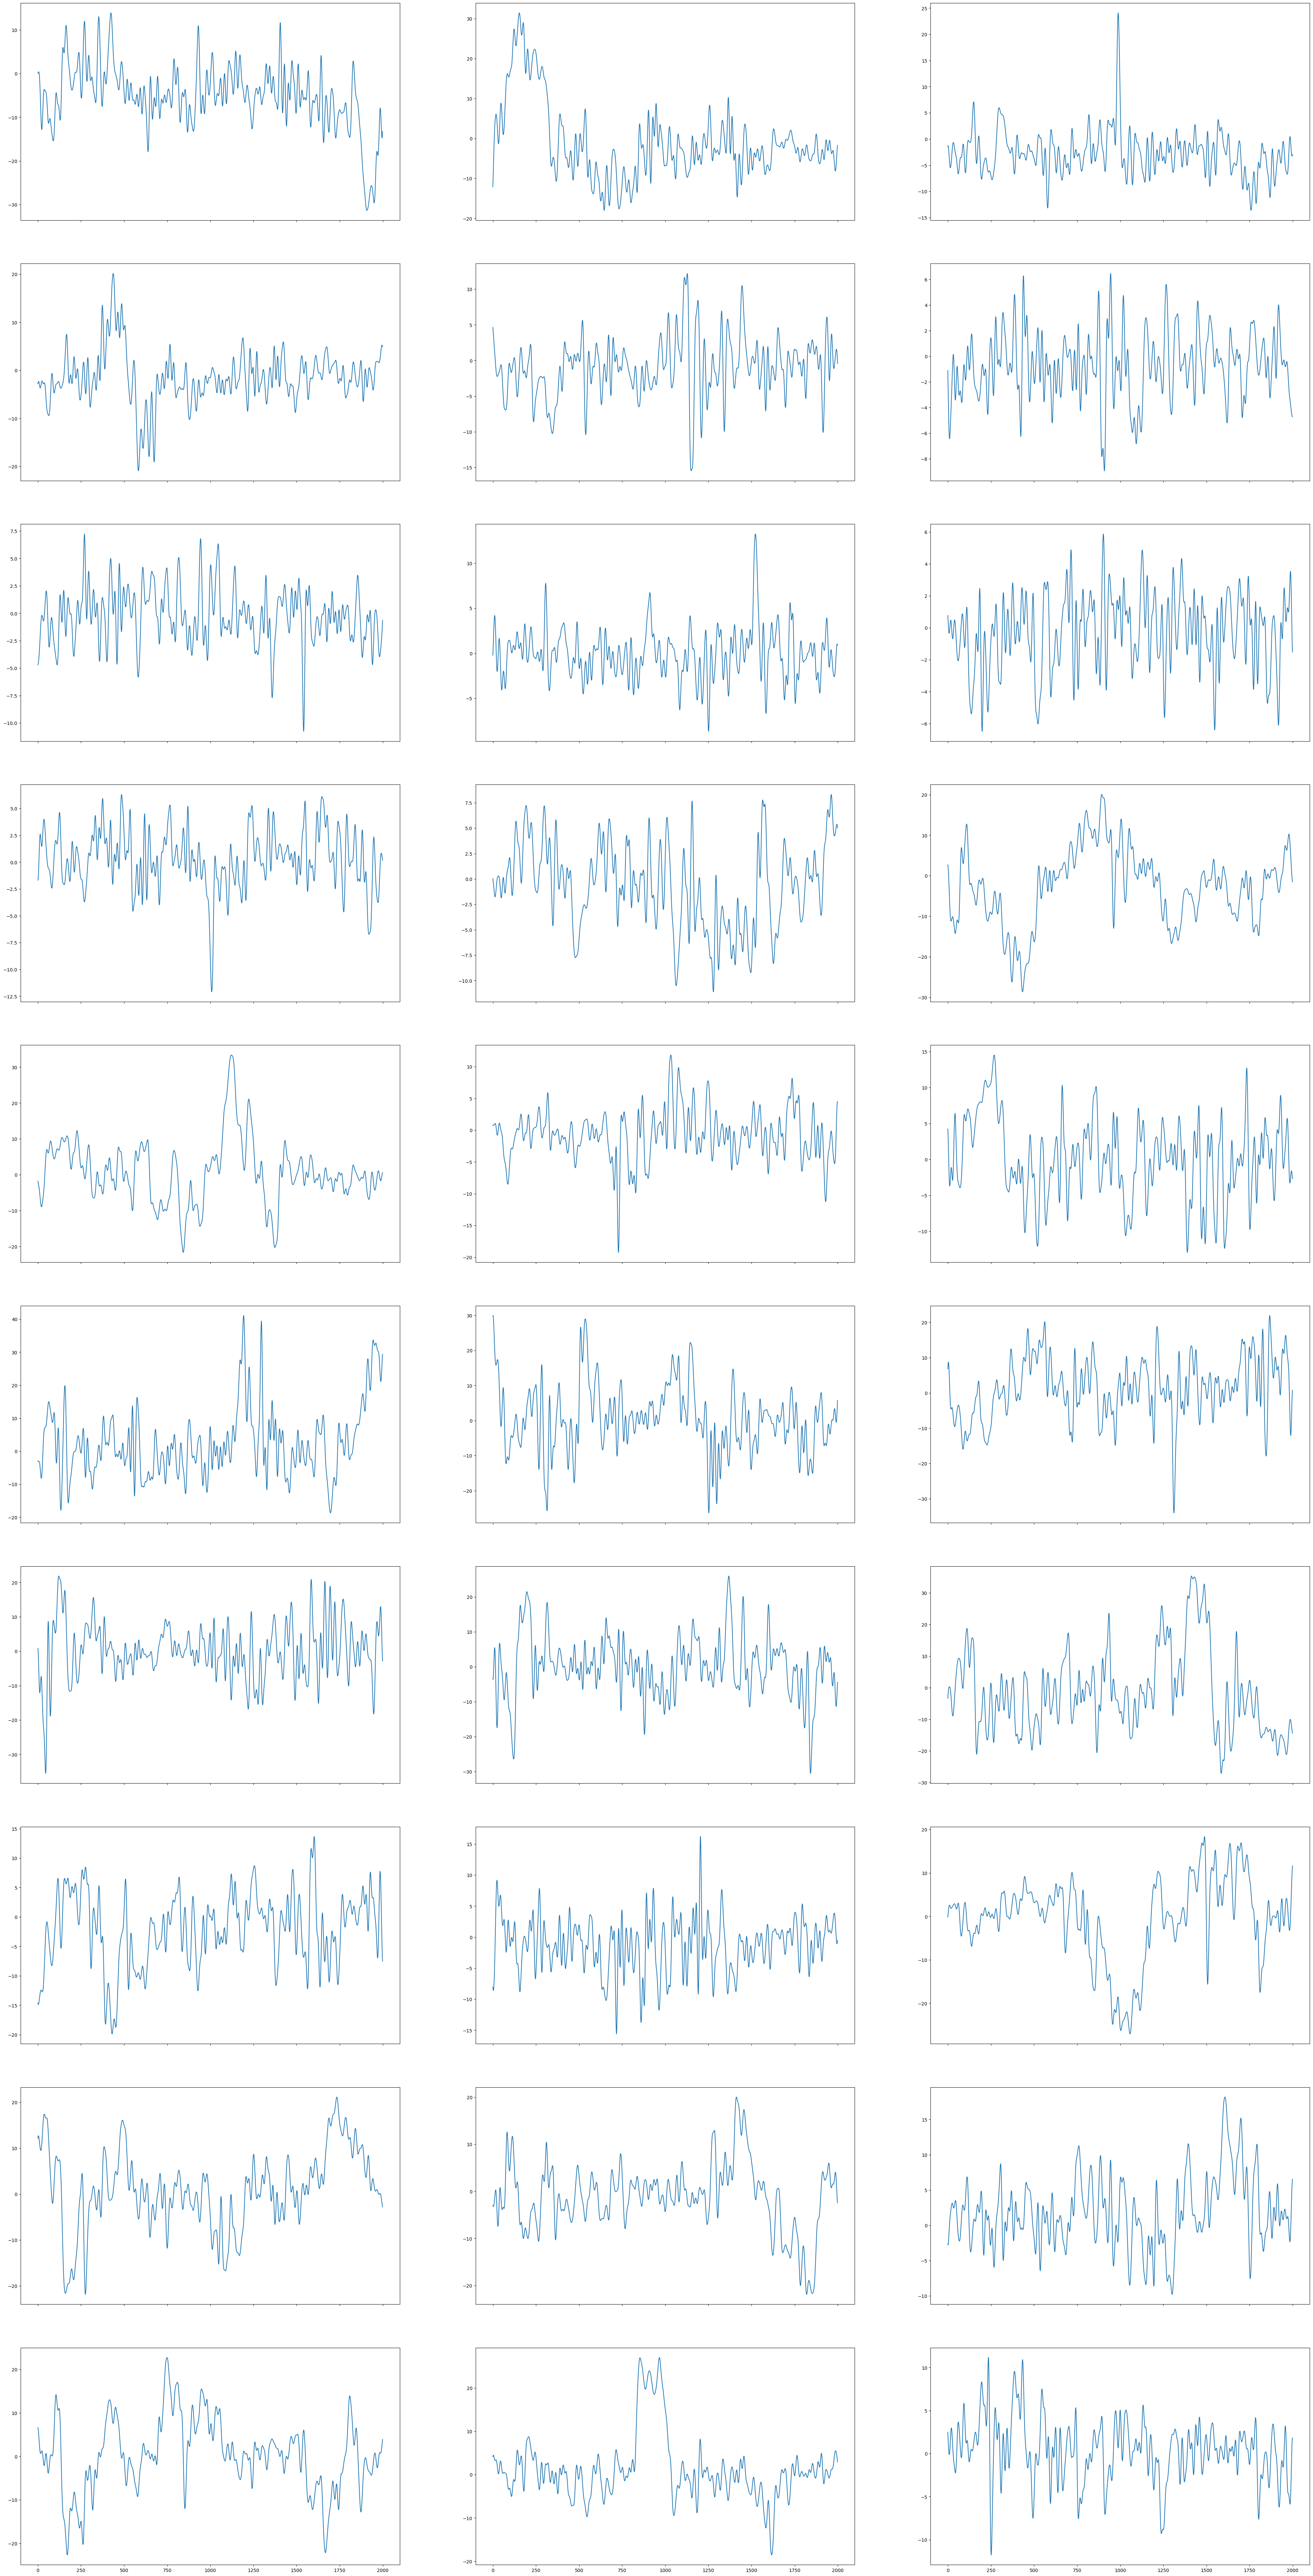

In [14]:
fig, axs = plt.subplots(10, 3, figsize=(50, 100), sharex=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(segment[indices[i]])

In [15]:
data = segment[indices]
data_new = np.concatenate(data)[np.newaxis,:]
data_new.shape

(1, 1900000)

In [16]:
sampling_freq = 2000
info = mne.create_info(['AVG'], sfreq=sampling_freq, ch_types=['eeg'])
raw_avg = mne.io.RawArray(data_new, info)

Creating RawArray with float64 data, n_channels=1, n_times=1900000
    Range : 0 ... 1899999 =      0.000 ...   950.000 secs
Ready.


Using matplotlib as 2D backend.


QSocketNotifier: Can only be used with threads started with QThread
inotify_add_watch(/home/desktop/.config/ibus/bus/7818ba96ad61454fa7e9d99240d0c71b-unix-wayland-0) failed: (No space left on device)
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

qt.qpa.wayland: Failed to initialize EGL display 3001
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


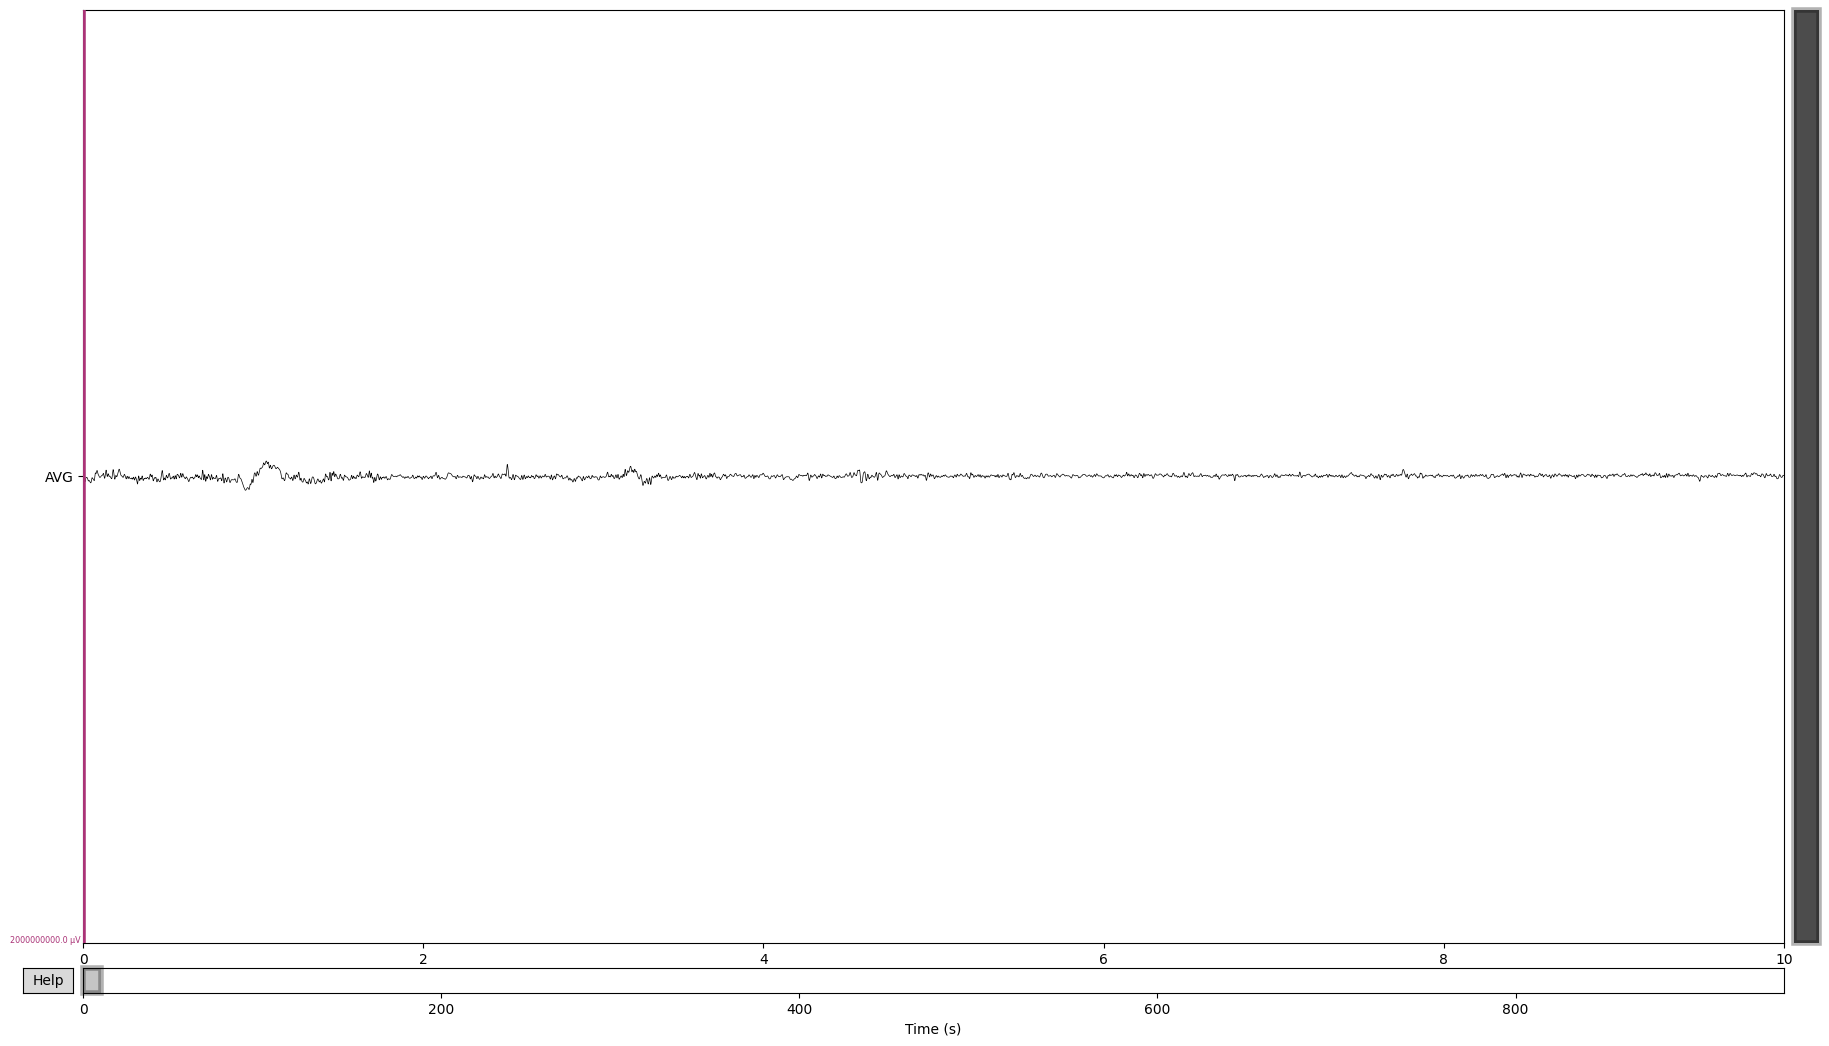

In [17]:
%matplotlib qt
raw_avg.plot(scalings = 1e3)

## Through DBSCAN followed by z-score
1. Removed 59 seconds data.
2. Very strict in cleaning the data.

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feat)

Channels marked as bad:
none


In [ ]:
from sklearn.cluster import DBSCAN

# Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan.fit(features_scaled)

# Extract cluster labels
labels = dbscan.labels_

# -1 indicates noise (potential artifacts)
print(f"Cluster labels: {labels}")

Cluster labels: [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
artifacts = np.where(labels == -1)[0]

In [ ]:
artifacts

array([ 11, 213, 214, 241, 242, 274, 275, 276, 277, 278, 279, 293, 294,
       418, 427, 442, 443, 459, 460, 473, 474])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the clusters
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering Results')
plt.colorbar(label='Cluster Label')
plt.show()


/tmp/ipykernel_19235/3536250390.py:10: UserWarning: Matplotlib is currently using Qt5Agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [ ]:
non_artifact = np.where(labels == 0)[0]
data = segment[non_artifact]
data.shape

(979, 2000)

In [ ]:
data_new = np.concatenate(data)[np.newaxis,:]
data_new.shape

(1, 1958000)

In [ ]:
sampling_freq = 2000
info = mne.create_info(['AVG'], sfreq=sampling_freq, ch_types=['eeg'])
raw_avg = mne.io.RawArray(data_new, info)

Creating RawArray with float64 data, n_channels=1, n_times=1958000
    Range : 0 ... 1957999 =      0.000 ...   979.000 secs
Ready.


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


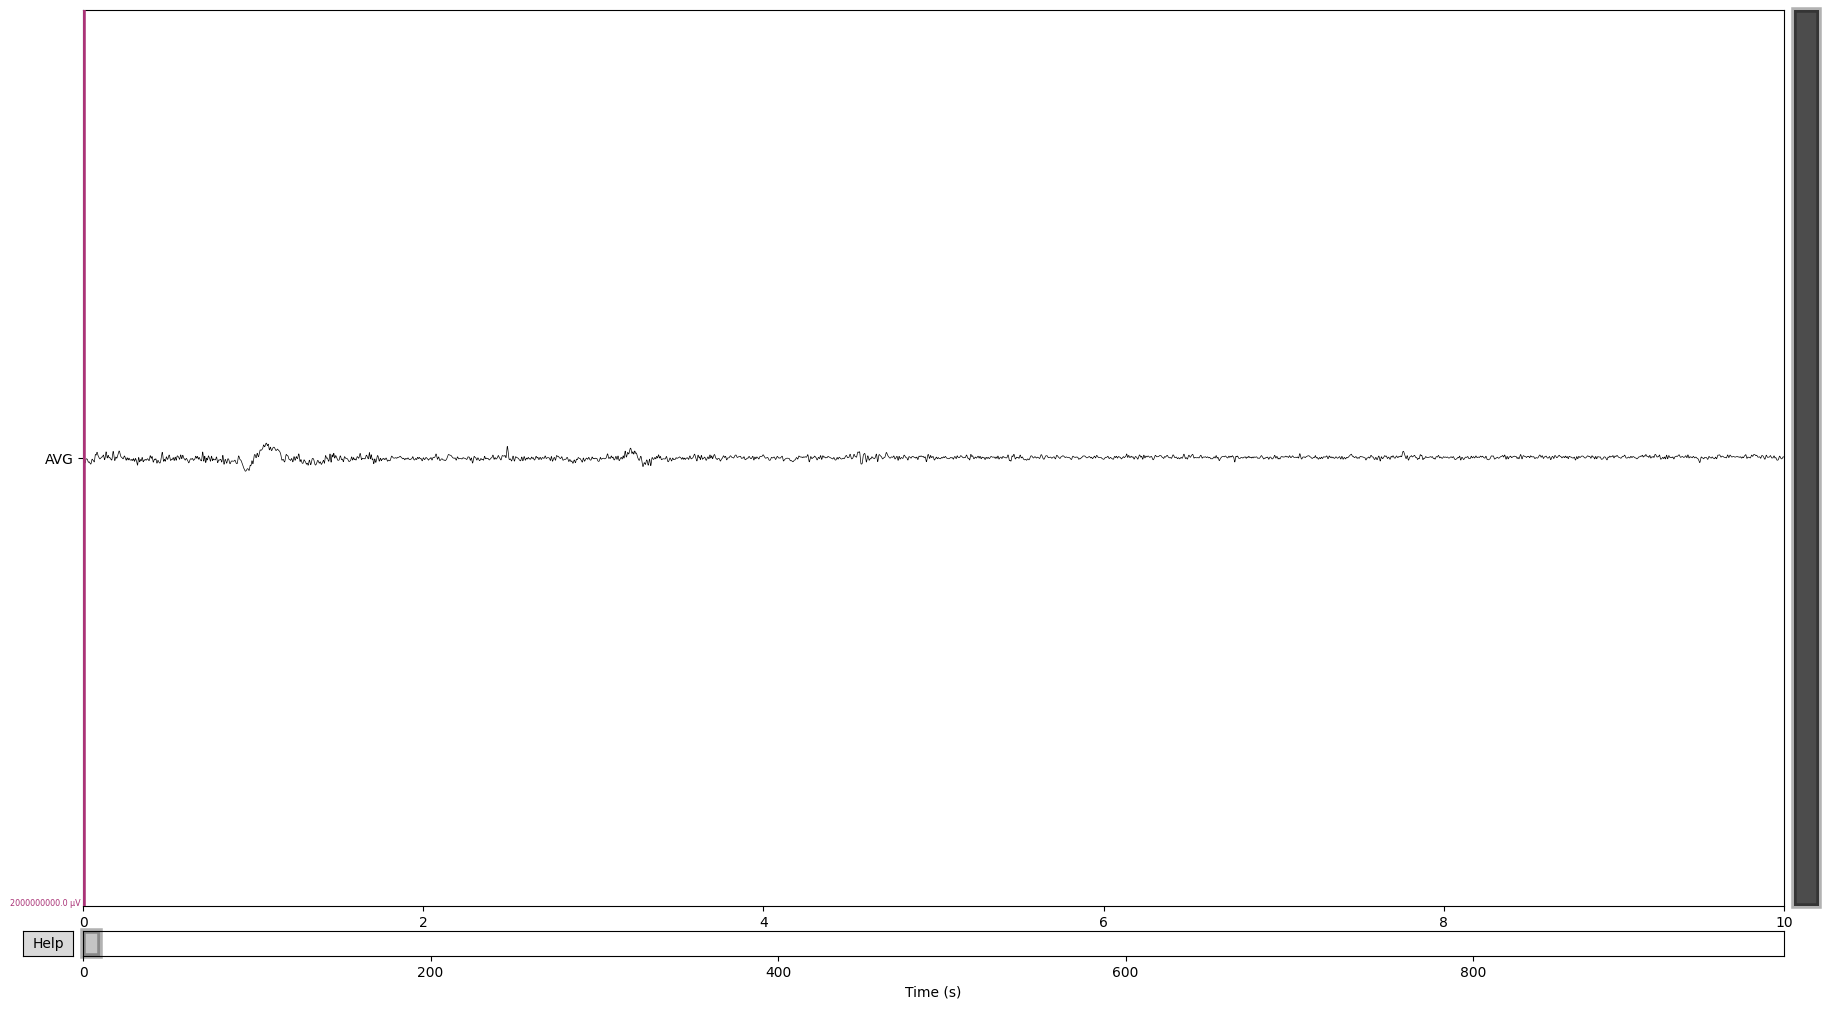

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt
raw_avg.plot(scalings = 1e3)

In [ ]:
features_scaled.shape

(1000, 4)

In [ ]:
normal = np.where(labels == 0)[0]

In [ ]:
data = features_scaled[normal]
data.shape

(979, 4)

In [ ]:
df = pd.DataFrame(data, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4'])

In [ ]:
mean = df.mean()
std_dev = df.std()

mean, std_dev

(Feature1   -0.108990
 Feature2   -0.015112
 Feature3   -0.109092
 Feature4   -0.104483
 dtype: float64,
 Feature1    0.077303
 Feature2    0.148686
 Feature3    0.077449
 Feature4    0.057279
 dtype: float64)

In [ ]:
# Calculate z-scores for each feature
z_scores = (df - mean) / std_dev

# Define a threshold for identifying outliers
threshold = 3.5

# Identify outliers
outliers = np.abs(z_scores) > threshold

outlier_indices = np.where(outliers.any(axis=1))[0].tolist()

# Print the list of indices
print("Indices of outliers detected:")
print(outlier_indices)

Indices of outliers detected:
[11, 196, 197, 211, 237, 265, 266, 267, 268, 269, 271, 280, 281, 282, 333, 342, 380, 382, 383, 394, 397, 398, 399, 411, 412, 413, 424, 425, 427, 428, 429, 439, 440, 441, 442, 443, 444, 445]


In [ ]:
non_outliers = np.where(~outliers.any(axis=1))[0]

In [ ]:
len(outlier_indices)

38

In [ ]:
data_eeg = segment[non_artifact]

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(100, 30), sharex=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(data_eeg[outlier_indices[i]])

In [ ]:
data_new = data_eeg[non_outliers]
data_new.shape

(941, 2000)

In [ ]:
data_new = np.concatenate(data_new)[np.newaxis,:]
data_new.shape

(1, 1882000)

In [ ]:
sampling_freq = 2000
info = mne.create_info(['AVG'], sfreq=sampling_freq, ch_types=['eeg'])
raw_avg = mne.io.RawArray(data_new, info)

Creating RawArray with float64 data, n_channels=1, n_times=1882000
    Range : 0 ... 1881999 =      0.000 ...   941.000 secs
Ready.


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


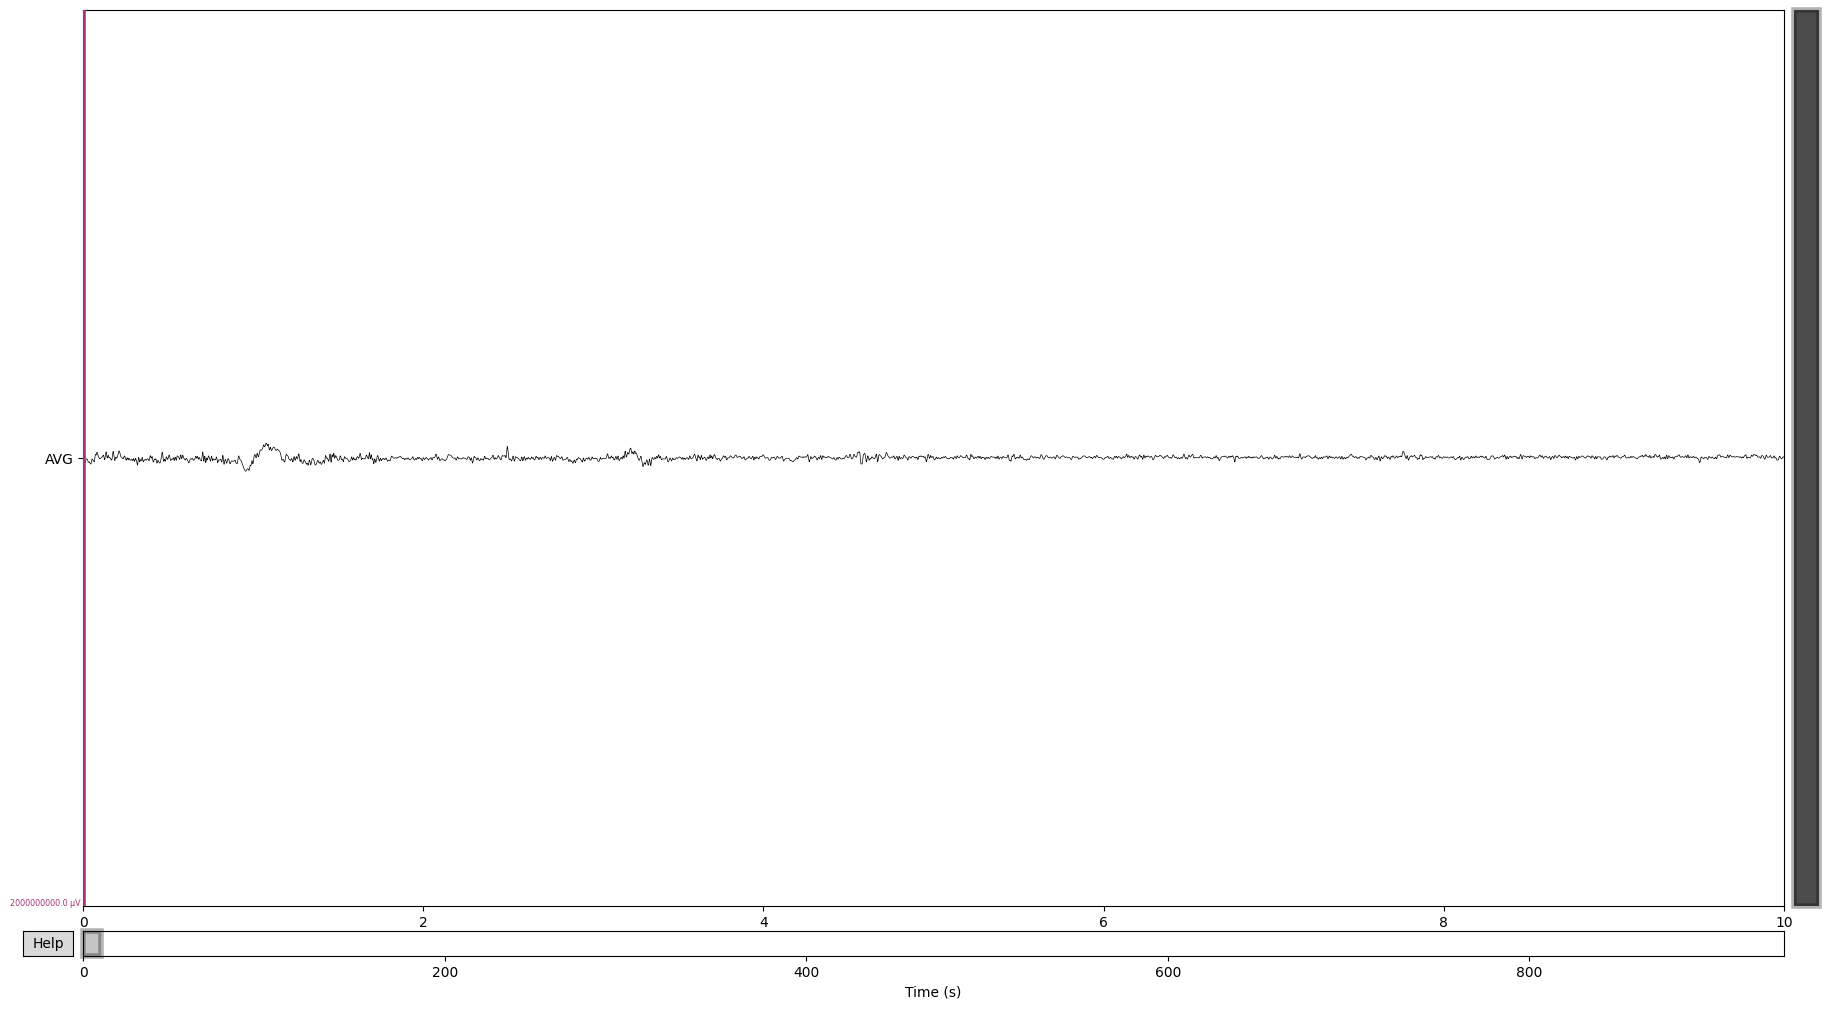

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt
raw_avg.plot(scalings = 1e3, title= 'cleaned')

## Saving the data cleaned by std. deviation using 95% as threshold

In [ ]:
data = sio.loadmat('Data_Testing_pre_cleaning.mat')['data_4']
data.shape

(4, 2000000)

In [ ]:
data = data.transpose()

In [ ]:
stride = 1
window = 1
sr = 2000

segments = []

numsamples = int(data.shape[0]/(window*sr))
for i in range(numsamples):
    segments.append(data[int(i*stride*sr):int((stride*(i+1))*sr),:])


segment = np.array(segments)
segment.shape

(1000, 2000, 4)

In [ ]:
segment = segment[indices,:,:]
segment.shape

(950, 2000, 4)

In [ ]:
sio.savemat('Cleaned_MEpi_Data.mat',{'data': segment,
                                     'indices': indices})

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
